#1. Creación de la base de datos

In [8]:
######################
#Librerías necesarias
######################

#Librerías de python y google colab
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import random
import copy
import itertools
from google.colab import drive

#Pandas
import pandas as pd

#Pytorch
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from skimage import io
from torch.utils.data.dataset import Subset
from torchvision.transforms.transforms import FiveCrop
from torchvision import models
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import sampler, random_split
from torch.utils.data.dataloader import DataLoader
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.activation import ReLU
from torchsummary import summary
from torch.hub import load_state_dict_from_url

#Scikit Learn
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [2]:
#Asociar la cuenta de Google Drive con el cuaderno para leer los archivos .tar

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Extracción de los archivos .tar (Deben estar subidos a la cuenta de google Drive)

data_dir = "/content/data"

#Extracción de train (cambiar directorio)
tar = tarfile.open("/content/drive/MyDrive/TFG/train_set.tar")
tar.extractall(data_dir)
tar.close()

#Extraemos test (cambiar directorio)
tar = tarfile.open("/content/drive/MyDrive/TFG/val_set.tar")
tar.extractall(data_dir)
tar.close()

In [4]:
#Clase AffectNet para el conjunto de entrenamiento


class AffectNetDataset_train(Dataset):
  def __init__(self, csv_file, root_dir, transform = None):
    self.annotations= pd.read_csv(csv_file)#leemos el archivo csv
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    
    #Para obtener cada uno de los elementos, la primera columna se corresponde con la ruta a las imágenes
    img_path=os.path.join(self.root_dir, self.annotations.iloc[index,0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index,1]))
    

    if self.transform:
      #Convertimos las imágenes a PIL, las aumentamos y hacemos el crop de tamaño 224x224
      
      transformation = transforms.Compose([transforms.ToPILImage(), transforms.Resize(256),transforms.FiveCrop(224)])

      #Elegimos una de las 5 imágenes aleatoriamente

      img= random.choice(transformation(image))

      #Aplicamos el resto de transformaciones pasadas como argumento(normaliación y conversión a tensor)
      image = self.transform(img)
      
    return (image, y_label)

In [5]:
#Clase AffectNet para el conjunto de test

class AffectNetDataset_test(Dataset):
  def __init__(self, csv_file, root_dir, transform = None):

    self.annotations= pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    
    img_path=os.path.join(self.root_dir, self.annotations.iloc[index,0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index,1]))
    
    img = self.transform(image)
    
    return (img, y_label)

In [6]:
#Media y desviación estándar calculadas para la base de datos (previamente calculadas)

mean = torch.tensor([0.5694, 0.4460, 0.3912])
std = torch.tensor([0.2747, 0.2446, 0.2383])


#Creamos la transformación aplicada al conjunto de entrenamiento
train_trans = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                  transforms.Normalize(mean= mean, std = std)])

#Transformación aplicada al connjunto de validación y test
transform= transforms.Compose([transforms.ToPILImage(), transforms.Resize(256),transforms.CenterCrop(224), 
                               transforms.ToTensor(), transforms.Normalize(mean= mean, std = std)])


#Creamos los objetos AffectNet que contendrán las imágenes y sus etiquetas 
train_dir= "/content/data/train_set/images"
train_dataset = AffectNetDataset_train(csv_file='AffectNet.csv', root_dir = train_dir, transform = train_trans)
val_train_dataset = AffectNetDataset_test(csv_file='AffectNet.csv', root_dir = train_dir, transform = transform)


#Realizamos la separación entre train y validación
indices = list(range(len(train_dataset)))
train_count = int(len(train_dataset) * 0.95)
val_count = len(train_dataset) - train_count
np.random.shuffle(indices)

train_idx= indices[:train_count] 
valid_idx= indices[train_count:len(train_dataset)]


#Obtenemos los datasets de train y validación
train_data = Subset(train_dataset, indices = train_idx)
val_train_data = Subset(val_train_dataset, indices = valid_idx)



#Hacemos lo mismo para el conjunto de test

val_dir= "/content/data/val_set/images"

transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean= mean, std = std)])
val_dataset = AffectNetDataset_test(csv_file='AffectNet_val.csv', root_dir = val_dir,
                                 transform = transform)


In [7]:
#Creamos el weighted random sampler para equilibrar los batches (pesos obtenidos previamente)

train_sample_weights = [0] * len(train_data)

val_sample_weights = [0] * len(val_train_data)

train_weights = torch.tensor([1.3356e-05, 7.4397e-06, 3.9279e-05, 7.0972e-05, 1.5679e-04, 2.6295e-04, 4.019e-05, 2.6667e-04])


#Para cada elemento guardamos en el array sample_weights el peso correspondiente para luego meterlo al subsampler
for idx, (data, label) in enumerate(train_data):
  
  train_weight = train_weights[label]
  train_sample_weights[idx] = train_weight

for idx, (data, label) in enumerate(val_train_data):
  
  val_weight = train_weights[label]
  val_sample_weights[idx] = val_weight
 

#print(sample_weights)

train_sampler = sampler.WeightedRandomSampler(train_sample_weights, num_samples = len(train_sample_weights), replacement = True)
val_train_sampler = sampler.WeightedRandomSampler(val_sample_weights, num_samples = len(val_sample_weights), replacement = True)


In [9]:
#Creación de los Dataloaders para entrar a la red

train_loader = DataLoader(dataset = train_data, batch_size = 64, sampler = train_sampler)
val_train_loader = DataLoader(dataset = val_train_data, batch_size = 64, sampler = val_train_sampler)
val_loader = DataLoader(dataset = val_dataset, batch_size = 64, shuffle=True)

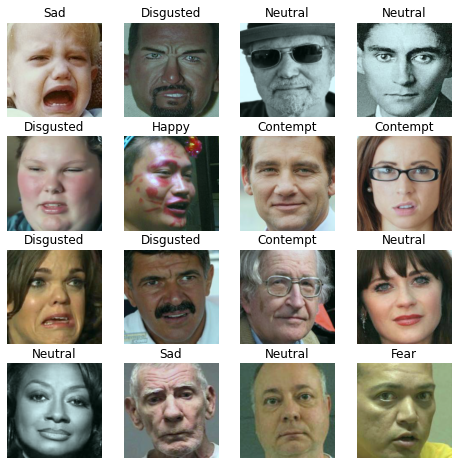

In [10]:
#Visualización de algunas imágenes y sus etiquetas

labels_map ={
    0: "Neutral",
    1: "Happy",
    2: "Sad",
    3: "Surprised",
    4: "Fear",
    5: "Disgusted",
    6: "Anger",
    7: "Contempt",
   }

figure = plt.figure(figsize=(8,8))
cols, rows = 4,4

def imshow(img):

    img = img*np.array([[[0.229]], [[0.224]], [[0.225]]]) + np.array([[[0.485]], [[0.456]], [[0.406]]]) 
    npimg = img.numpy()-img.numpy().min()
    npimg = npimg/npimg.max()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


for i in range(1, cols*rows +1):
  train_image, train_label = next(iter(val_loader))
  img = train_image[0]
  label = train_label[0]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label.item()])
  plt.axis("off")
  imshow(img)
plt.show()

# 2. Funciones auxiliares para el proceso de entrenamiento

In [11]:
#Funciones encargadas de guardar el estado de la red y cargarlos

def save_checkpoint(state, filename= "my_checkpoint.pth.tar"):
  print("=>Saving checkpoint")
  torch.save(state, filename)


def load_checkpoint(checkpoint):
  
  scheduler.load_state_dict(checkpoint['scheduler'])
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  epoch = checkpoint['epoch']
  
  print(epoch)
  print("=>Loading checkpoint from epoch ",epoch)
  return epoch

In [12]:
#Funcion de evaluacion

def eval_model (loader, model, device):
  loss =[]
  correctas=0
  muestras=0

#Ponemos el modelo en modo evaluación
  model.eval()
  
  with torch.no_grad():#desactivamos los gradientes
    for image, label in loader:
      image = image.to(device=device)
      label = label.to(device=device)
      

      scores = model(image)
      loss.append(nn.functional.cross_entropy(scores, label).data.cpu().numpy())
      _, preds = scores.max(1)
    
      correctas += (preds == label).sum()
      muestras += preds.size(0)
    
    acc = float(correctas)/muestras
    mean_loss = np.mean(loss)
    print("%d / %d correctas (%.2f)" % (correctas, muestras, 100*acc))
    print("Loss con el test= %.2f" %mean_loss)

  return acc, mean_loss

In [13]:
#Función que maneja el algoritmo de entrenamiento. Explicada en detalle en el Anexo 2

#Número de iteraciones para las que obtenemos resultados
imprimir=500


#Tendrá como argumentos de entrada el modelo, el optimizador para retropropagar la última capa, y el numero de epochs

def training_loop (model, optimizer, scheduler, num_epochs=1,  device= torch.device('cuda')):
  
  best_model= copy.deepcopy(model.state_dict())
  best_accuracy = 0.0
  
  #Variables para las gráficas

  loss_iteracion = []
  loss_iter_aux =[]
  loss_iter_aux_val = []
  loss_epoch =[]
  loss_epoch_val =[]
  lrs=[]
  validation_accuracy_epoch = []
  validation_train_accuracy_epoch = []
  plt.figure(1)

  model = model.to(device= device)

#Para cada época
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-'*10)

#Para cada batch
    for t,(image, label) in enumerate(train_loader):
      #Ponemos el modelo en modo entrenamiento
        model.train()
        image = image.to(device=device)
        label= label.to(device=device)
        
        #Obtenemos las predicciones
        scores = model(image)
        
        #A partir de las predicciones obtenemos la función de pérdidas
        loss = nn.functional.cross_entropy(scores, label)
        print(loss)

        #Guardamos el valor de pérdida de cada iteración para su posterior representación
        loss_iteracion.append(loss.data.cpu().numpy())
        loss_iter_aux.append(loss.data.cpu().numpy())
        
        #Inicializamos los gradientes para comenzar el proceso de retropropagación
        optimizer.zero_grad()

        #retropropagamos
        loss.backward()

        #actualizamos los pesos usando los gradientes calculados al retropropagar
        optimizer.step()

        lr=optimizer.param_groups[0]["lr"]

#Cuando el número de batch coincida con el valor puesto para obtener resultados
        if t % imprimir == 0:

          #CObtenemos métricas (accuracy, pérdida media)
          print('Iteracion %d, loss al propagar hacia adelante = %.4f, LR = %.7f' % (t, loss.item(), lr))
          accuracy, mean_loss = eval_model(val_train_loader, model, device)
          loss_iter_aux_val.append(mean_loss)
       
          #Guardamos historia de la mejor precisión hasta el momento
          if accuracy > best_accuracy:
            best_accuracy= accuracy
          
          print("Best accuracy of all", best_accuracy)

          print()
    
    #Al final de cada época guardamos el estado de la red
    if epoch % 1 == 0:
      checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : optimizer.state_dict(), 'epoch' : epoch, 'scheduler': scheduler.state_dict()}

      save_checkpoint(checkpoint)


    #Calculamos el valor de pérdida de la época 
    loss_epoch.append(np.mean(loss_iter_aux))
    loss_epoch_val.append(np.mean(loss_iter_aux_val))
    lrs.append(lr)

    #Vaciamos los arrays de las iteraciones puesto que vamos a empezar un nuevo epoch
    loss_iter_aux=[]
    loss_iter_aux_val=[]
    validation_train_accuracy, mean_loss = eval_model(val_train_loader, model, device)
    _, mean_loss = eval_model(val_loader, model, device)

    validation_train_accuracy_epoch.append(validation_train_accuracy)

    scheduler.step()



    plt.clf()
    plt.plot(np.arange(np.size(loss_epoch)), loss_epoch, label = "Train", marker = 'x')#eje x tamaño del array de epoch (nº de epochs), eje y valor del loss en el epoch
    plt.plot(np.arange(np.size(loss_epoch_val)), loss_epoch_val, label = "Validacion", marker = 'x')
    plt.xlabel("Numero de epochs")
    plt.ylabel("Loss")
    plt.legend(loc = "upper right")
    plt.show()
    plt.plot(np.arange(np.size(validation_train_accuracy_epoch)), validation_train_accuracy_epoch, label = "Validación", marker = 'x')
    
    plt.xlabel("Numero de epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc = "upper right")
    plt.show()

# 3. Creación de las redes

In [14]:
#Función que congela los pesos para el proceso de fine-tuning

def gradiente_ultima_capa(model, feature_extraction):
  if feature_extraction:
    for param in model.parameters():
      param.requires_grad = False 


In [15]:
#AlexNet

feature_extraction = True

#Cargamos el modelo

model_ft= models.alexnet(pretrained = True)

#Obtenemos la última capa
num_in= model_ft.classifier[6].in_features

#Editamos la ultima capa
num_clases=8
gradiente_ultima_capa(model_ft, feature_extraction)
model_ft.classifier[6] = nn.Linear(num_in, num_clases)

#Obtenemos por pantalla el modelo
print(model_ft)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Imprimimos un resumen
summary(model_ft.to(device = device), (3, 224, 224))


for name, param in model_ft.named_parameters():
  if param.requires_grad:print(name)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#ResNet 18

feature_extraction = True

model_ft= models.resnet18(pretrained = True)
gradiente_ultima_capa(model_ft, feature_extraction)
num_in= model_ft.fc.in_features
num_clases=8
model_ft.fc = nn.Linear(num_in, num_clases)

print(model_ft)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
summary(model_ft.to(device = device), (3, 224, 224))


for name, param in model_ft.named_parameters():
  if param.requires_grad:print(name)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Inception

#Para ejecutar Inception se deben cambiar los tamaños en AffectNet_train
#y AffectNet_test a 299

feature_extraction = True

model_ft= models.inception_v3(pretrained = True)
gradiente_ultima_capa(model_ft, feature_extraction) 
num_in= model_ft.fc.in_features

num_clases=8
model_ft.fc = nn.Linear(num_in, num_clases)

print(model_ft)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
summary(model_ft.to(device = device), (3, 299, 299))


for name, param in model_ft.named_parameters():
  if param.requires_grad:print(name)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
#Diseño propio

#Sin capas convolucionales 1x1
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.cnn_layers = nn.Sequential(
            
            #Capa 1
            nn.Conv2d(in_channels=3, out_channels= 64, kernel_size= 3, stride=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
           
            #3x3
            nn.Conv2d(in_channels=64, out_channels= 64, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
           
            #Pooling
            nn.MaxPool2d(kernel_size=3, stride=2),

            #Capa 2
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            #3x3
            nn.Conv2d(in_channels=128, out_channels= 128, kernel_size= 3, stride=1, padding=1),#13x13x10
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),#5x5x128

            #Capa 3
            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size= 3, stride=1, padding=1),#5x5x256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            #3x3
            nn.Conv2d(in_channels=256, out_channels= 256, kernel_size= 3, stride=1, padding=1),#5x5x10
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),#4x4x256

        )
        

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 8),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
# Con capas convolucionales 1x1

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.cnn_layers = nn.Sequential(
            
            #Capa 1
            nn.Conv2d(in_channels=3, out_channels= 64, kernel_size= 3, stride=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
          
            #3x3
            nn.Conv2d(in_channels=64, out_channels= 64, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),#37x37x64

            #Capa 2
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            #1x1
            nn.Conv2d(in_channels=128, out_channels= 32, kernel_size= 1, stride=1, padding=0),
            #3x3
            nn.Conv2d(in_channels=32, out_channels= 32, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            #1x1
            nn.Conv2d(in_channels=32, out_channels= 128, kernel_size= 1, stride=1, padding=0),
            #Pooling
            nn.MaxPool2d(kernel_size=3, stride=2),

            #Capa 3
            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #1x1
            nn.Conv2d(in_channels=256, out_channels= 32, kernel_size= 1, stride=1, padding=0),
            #3x3
            nn.Conv2d(in_channels=32, out_channels= 32, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            #1x1
            nn.Conv2d(in_channels=32, out_channels= 256, kernel_size= 1, stride=1, padding=0),
            #Pooling
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 8),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
#Velocidad de bajada de resolucion lenta

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.cnn_layers = nn.Sequential(
            
            #Capa 1
            nn.Conv2d(in_channels=3, out_channels= 64, kernel_size= 3, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            #3x3
            nn.Conv2d(in_channels=64, out_channels= 64, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            #Pooling
            nn.MaxPool2d(kernel_size=3, stride=2),

            #Capa 2
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            #1x1
            nn.Conv2d(in_channels=128, out_channels= 32, kernel_size= 1, stride=1, padding=0),
            #3x3
            nn.Conv2d(in_channels=32, out_channels= 32, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            #1x1
            nn.Conv2d(in_channels=32, out_channels= 128, kernel_size= 1, stride=1, padding=0),
            #Pooling
            nn.MaxPool2d(kernel_size=3, stride=2),#5x5x128

            #Capa 3
            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #1x1
            nn.Conv2d(in_channels=256, out_channels= 32, kernel_size= 1, stride=1, padding=0),
            #3x3
            nn.Conv2d(in_channels=32, out_channels= 32, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            #1x1
            nn.Conv2d(in_channels=32, out_channels= 256, kernel_size= 1, stride=1, padding=0),
            #Pooling
            nn.MaxPool2d(kernel_size=3, stride=2),


            #Capa 4
            nn.Conv2d(in_channels=256, out_channels= 512, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #1x1
            nn.Conv2d(in_channels=512, out_channels= 32, kernel_size= 1, stride=1, padding=0),
            #3x3
            nn.Conv2d(in_channels=32, out_channels= 32, kernel_size= 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            #1x1
            nn.Conv2d(in_channels=32, out_channels= 512, kernel_size= 1, stride=1, padding=0),
            #Pooling
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 8),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
model_ft = MyNet()
print(model_ft)

MyNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128,

# 4. Entrenamimento

# 4.1 Redes preentrenadas

In [16]:
#Comprobación de las capas a actualizar
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extraction:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [17]:
# Entrenamiento de la última capa

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate =1e-5
optimizer = optim.SGD(params_to_update, lr= learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size =11, gamma = 0.1, verbose = True)


best_model = training_loop (model_ft, optimizer, scheduler, num_epochs = 6, device= device)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 1/6
----------
tensor(2.3167, grad_fn=<NllLossBackward0>)
Iteracion 0, loss al propagar hacia adelante = 2.3167, LR = 0.0000100


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
#Ejecución en caso de empezar el entrenamiento desde un punto
num_epoch = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate =1e-4
optimizer = optim.SGD(params_to_update, lr= learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size =11, gamma = 0.1, verbose = True)

epoch =load_checkpoint(torch.load("my_checkpoint.pth.tar"))
print(epoch)


best_model = training_loop (model_ft, optimizer, scheduler, num_epochs = num_epoch - epoch, device= device)

In [18]:
#Se descongela toda la red
for param in model_ft.parameters():
    param.requires_grad = True 

for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            
            print("\t",name)

	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [19]:
# Entrenamiento de toda la red

params_to_update = model_ft.parameters()#cogemos todos los parámetros
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate =1e-3
optimizer = optim.SGD(params_to_update, lr= learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size =10, gamma = 0.1, verbose = True)

best_model = training_loop (model_ft, optimizer, scheduler, num_epochs = 20, device= device)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1/20
----------


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [20]:
#Ejecución en caso de empezar el entrenamiento desde un punto
num_epoch = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate =1e-4
optimizer = optim.SGD(params_to_update, lr= learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size =11, gamma = 0.1, verbose = True)

epoch =load_checkpoint(torch.load("my_checkpoint.pth.tar"))
print(epoch)


best_model = training_loop (model_ft, optimizer, scheduler, num_epochs = num_epoch - epoch, device= device)

ValueError: ignored

# 4.2 Entrenamiento desde cero

In [ ]:
#Entrenamiento

params_to_update = model_ft.parameters()#cogemos todos los parámetros
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate =1e-2
optimizer = optim.SGD(params_to_update, lr= learning_rate, momentum=0.9, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size =10, gamma = 0.1, verbose = True)

best_model = training_loop (model_ft, optimizer, scheduler, num_epochs = 15, device= device)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1/15
----------


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
#En caso de querer ejecutar desde un punto de la red

num_epoch = 20
step = 9

params_to_update = model.parameters()#cogemos todos los parámetros
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate =1e-2
optimizer = optim.SGD(params_to_update, lr= learning_rate, momentum=0.9, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size =1, gamma = 0.1, verbose = True)

epoch =load_checkpoint(torch.load("my_checkpoint.pth (79).tar"))
print(epoch)

best_model = training_loop (model, optimizer, scheduler, num_epochs = num_epoch - epoch, device= device)

# 5. Evaluación

In [21]:
labels= ["Neutral", "Happy", "Sad", "Surprised", "Fear", "Disgusted", "Anger", "Contempt"]


#Matriz de confusion
def confusion_matrix(targets, predicciones, num_clases =8):
  matriz_confusion= np.zeros((num_clases, num_clases)).astype('int')
  stacked = np.stack((targets, predicciones), axis=1)#

  for p in stacked:
    tarlabel, predlabel = p.tolist();
    matriz_confusion[tarlabel, predlabel] = matriz_confusion[tarlabel, predlabel] +1
  
  return matriz_confusion


#AUC
fpr ={}
tpr={}
thresh={}
auc_score={}
auc_scores =[]

def auc(targets, predicciones, num_clases =8):

  classes= range(num_clases)

  for i in range(num_clases):
    fpr[i], tpr[i], thresh[i] = roc_curve(targets, predicciones[:,i], pos_label=i)
    auc_scores.append(metrics.auc(fpr[i], tpr[i]))

  
  softmax = torch.nn.Softmax()
  softmax_probs = softmax(torch.from_numpy(predicciones))
  softmax_probs.numpy()
  
  auc_score = roc_auc_score(targets, softmax_probs, multi_class='ovr')
  print(type(auc_score))

#Cada una de las curvas
  plt.clf
  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Neutral vs Rest')
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Happy vs Rest')
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Sad vs Rest')
  plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Surprised vs Rest')
  plt.plot(fpr[4], tpr[4], linestyle='--',color='yellow', label='Fear vs Rest')
  plt.plot(fpr[5], tpr[5], linestyle='--',color='black', label='Disgusted vs Rest')
  plt.plot(fpr[6], tpr[6], linestyle='--',color='purple', label='Anger vs Rest')
  plt.plot(fpr[7], tpr[7], linestyle='--',color='pink', label='Contempt vs Rest')
  
  plt.title('Curvas ROC. AUC = {}' .format(auc_score))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()
  
 #Gráfica del AUC para cada curva
  plt.bar(labels, auc_scores)
  plt.axhline(y=auc_score, linestyle = '--', color='red')
  plt.ylim(0.8,1)
  plt.show()


labels_map ={
    0: "Neutral",
    1: "Happy",
    2: "Sad",
    3: "Surprised",
    4: "Fear",
    5: "Disgusted",
    6: "Anger",
    7: "Contempt",
   }

#Matrz de confusión
def plot_confusion_matrix(cm, labels_map):
  print("Confusion matrix")

  plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
  plt.title("Matriz de confusion")
  plt.colorbar()
  tick_marks = np.arange(len(labels_map))
  plt.xticks(tick_marks, list(labels_map.values()), rotation=45 )
  plt.yticks(tick_marks, list(labels_map.values()))

  fmt = 'd'
  thresh = cm.max()/2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, format(cm[i,j], fmt), horizontalalignment ="center", color="white" if cm[i,j] > thresh else "black")#simplemente para imprimir el texto

  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()



In [22]:
#Algoritmo de evaluación

def eval_model_cm(loader, model, device = torch.device('cuda')):
   

    print('Checking accuracy on test set')
    loss = []
    correctas = 0
    muestras = 0
    label_all = []
    scores_all=[]
    preds_all = []
    model.eval()  
    count=0

    #Ponemos el modelo en evaluación
    with torch.no_grad():
        for image, label in loader:
            image = image.to(device=device)
            label = label.to(device=device)
            scores = model(image)
            count += 1
            
            loss.append(nn.functional.cross_entropy(scores, label).data.cpu().numpy())
            
            _, preds = scores.max(1)
            correctas += (preds == label).sum()
            muestras += preds.size(0)
            

            #Ahora guardaremos todas las labels y todas las predicciones para usarlas en la matriz de confusion
            scores_all.append(scores.data.cpu().numpy())
            label_all.append(label.data.cpu().numpy())
            preds_all.append(preds.data.cpu().numpy())
        
        #Calculamos la precisión
        acc = float(correctas) / muestras
        mean_loss = np.mean(loss)
        print('Got %d / %d correct (%.2f)' % (correctas, muestras, 100 * acc))
        print('Loss=%.2f' % mean_loss)

        #Calculamos la matriz de confusión y el AUC
        scores_all = np.concatenate(scores_all)
        label_all = np.concatenate(label_all)
        preds_all = np.concatenate(preds_all)
        cm = confusion_matrix(label_all, preds_all, num_clases=8)
        plot_confusion_matrix(cm, labels_map)
        auc(label_all, scores_all, num_clases=8)
        
    return acc, mean_loss, cm

In [23]:
eval_model_cm(val_loader, model_ft)

Checking accuracy on test set


RuntimeError: ignored